**INSTALL REQUIRED PACKAGES**

In [1]:
pip install yfinance pandas scikit-learn statsmodels pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


**IMPORT REQUIRED PACKAGES AND FUNCTIONS**

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

**DEFINE CUSTOM FUNCTIONS**

In [3]:
def load_adj_close_stock_data(company, start, end):
    data = yf.download(company, start=start, end=end)
    return data['Adj Close']

In [4]:
def load_adj_close_stock_data_in_chunks(company, start, end):
    pass

In [5]:
def visualize_adj_close_stock_data(company, data):
    plt.figure(figsize=(20,10))
    sns.set_style('darkgrid')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.title('{} Stock Market Closing Price'.format(company))
    plt.plot(data_adj_close)

In [6]:
def test_adf(timeseries):
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(moving_average, color='red', label='Rolling Mean')
    plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['Critical value (%s)'%key] = value
    print(output)

In [7]:
def visualize_seasonal_decomposition(data):
    result = seasonal_decompose(data, model='multiplicative', period=30)
    fig = plt.figure()
    fig = result.plot()
    fig.set_size_inches(16, 9)

In [8]:
def train_test_split(data):
    return data[:int(len(data) * 0.75)], data[int(len(data) * 0.75):]

In [9]:
def visualize_train_test_data(train_data, test_data):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(train_data, 'green', label='Train Data')
    plt.plot(test_data, 'blue', label='Test Data')
    plt.legend()

In [10]:
def convert_to_stationary(data):
    data_adj_close_log = np.log(data)
    moving_average = data_adj_close_log.rolling(12).mean()
    std_dev = data_adj_close_log.rolling(12).std()
    data_adj_close_log_minus_mean = data_adj_close_log - moving_average
    data_adj_close_log_minus_mean.dropna(inplace=True)
    test_adf(data_adj_close_log_minus_mean)
    return data_adj_close_log, data_adj_close_log_minus_mean

In [38]:
def visualize_forecast(company, test_data, fc):
    fc.index = test_data.index
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(test_data, color='blue', label='Actual Stock Price')
    plt.plot(fc, color='orange', label='Predicted Stock Price')
    plt.title('{} Stock Price Prediction'.format(company))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left')
    plt.show()

In [12]:
def print_model_performance(test_data, fc):
    mse = mean_squared_error(test_data, fc)
    mae = mean_absolute_error(test_data, fc)
    print('MSE: '+str(mse))
    print('MAE: '+str(mae))

**IT SECTOR ANALYSIS**

In [13]:
company = '^CNXIT'
start="2019-11-01"
end="2023-11-01"
data_adj_close = load_adj_close_stock_data(company, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


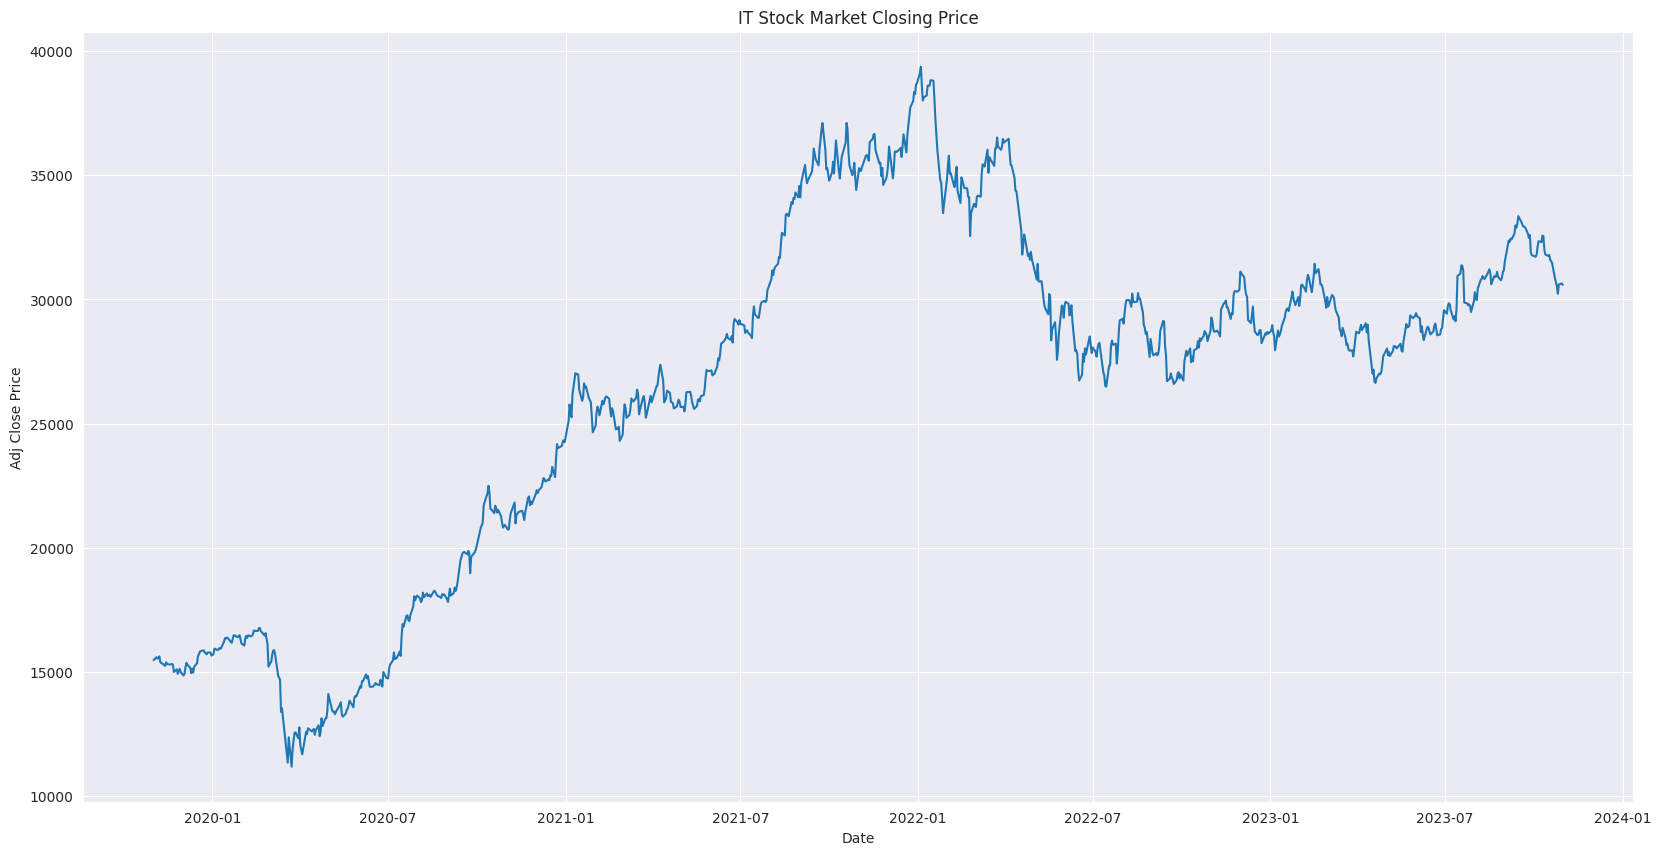

In [15]:
visualize_adj_close_stock_data("IT", data_adj_close)

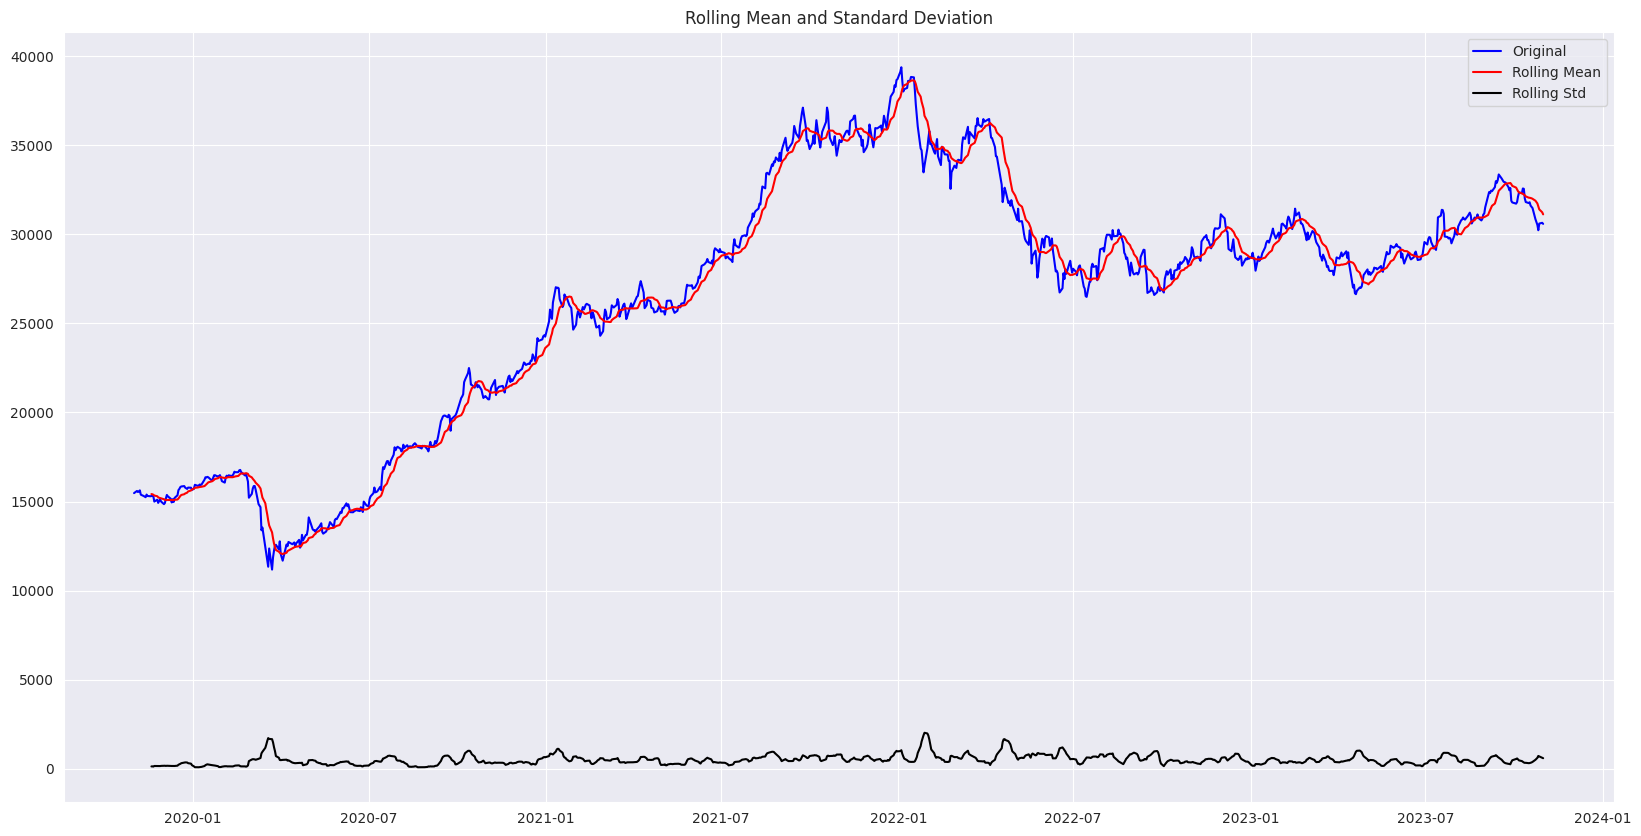

Results of dickey fuller test
Test Statistics                 -1.478796
p-value                          0.543973
No of lags used                  2.000000
Number of observations used    986.000000
Critical value (1%)             -3.436999
Critical value (5%)             -2.864476
Critical value (10%)            -2.568333
dtype: float64


In [16]:
test_adf(data_adj_close)

<Figure size 640x480 with 0 Axes>

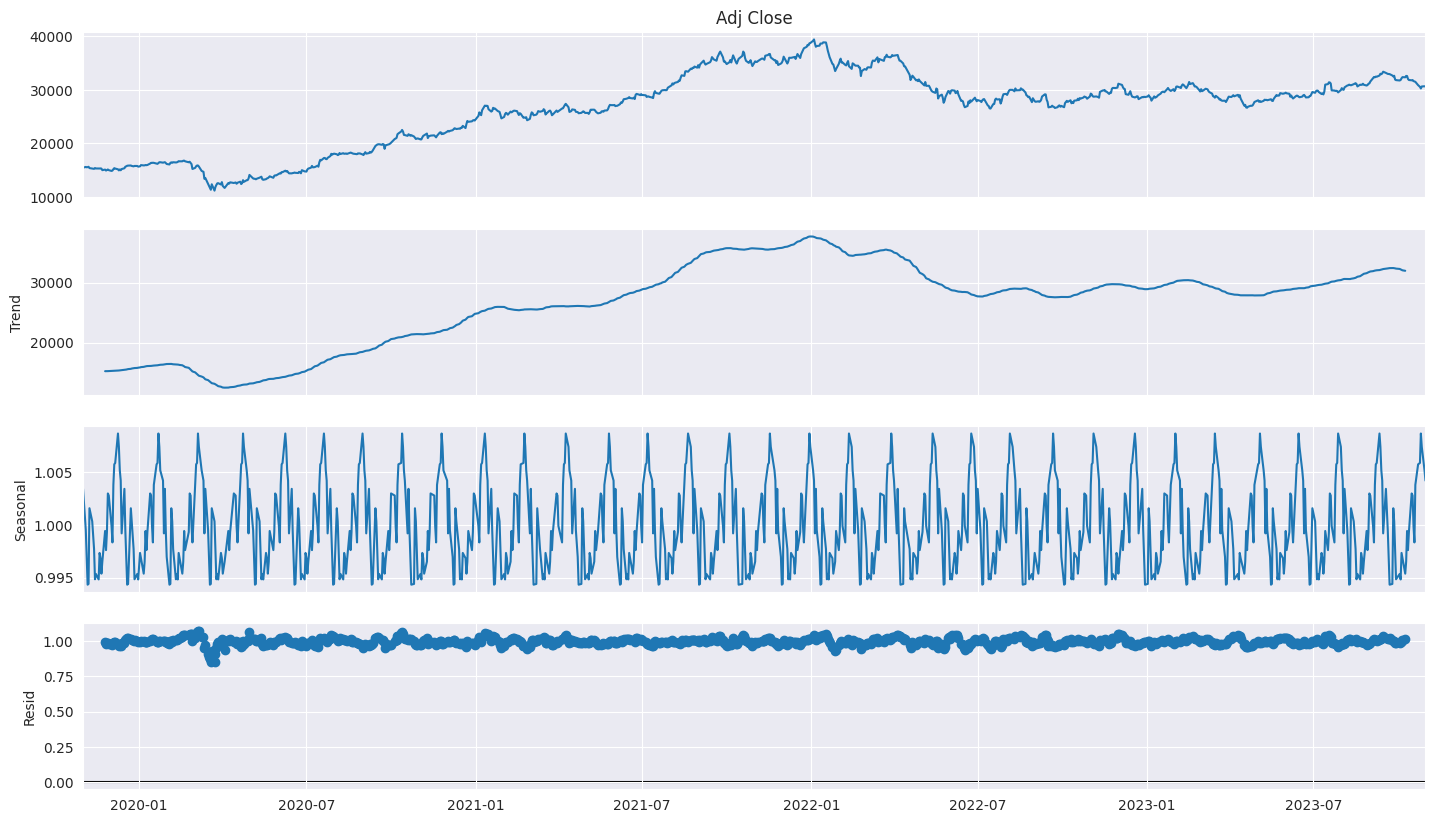

In [17]:
visualize_seasonal_decomposition(data_adj_close)

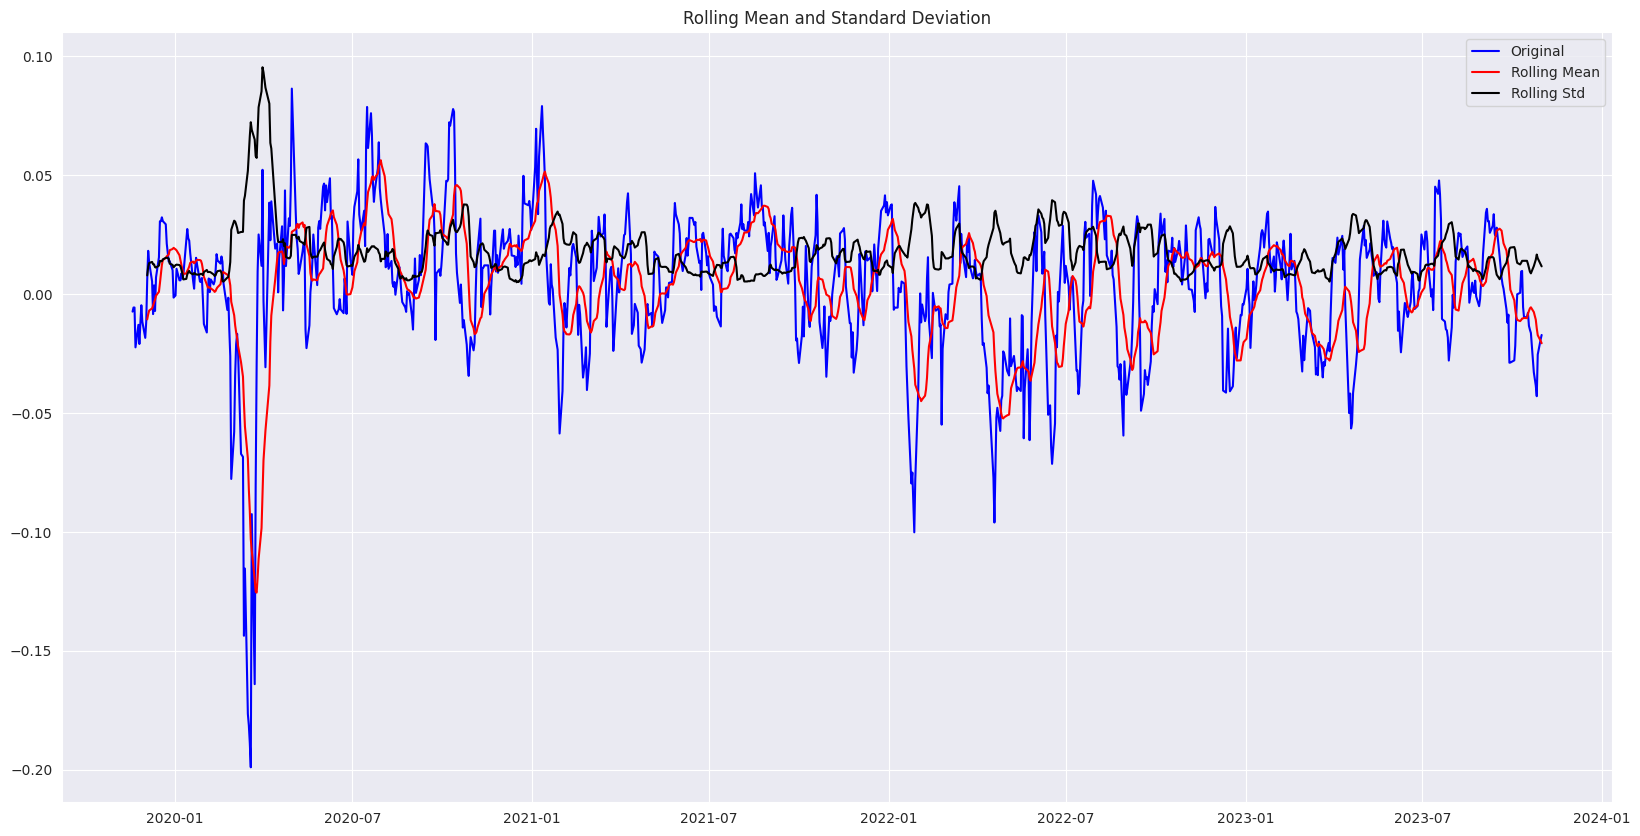

Results of dickey fuller test
Test Statistics               -5.710073e+00
p-value                        7.334258e-07
No of lags used                1.400000e+01
Number of observations used    9.630000e+02
Critical value (1%)           -3.437159e+00
Critical value (5%)           -2.864546e+00
Critical value (10%)          -2.568371e+00
dtype: float64


In [18]:
data_adj_close_log, data_adj_close_log_minus_mean = convert_to_stationary(data_adj_close)

In [19]:
train_data, test_data = train_test_split(data_adj_close_log)

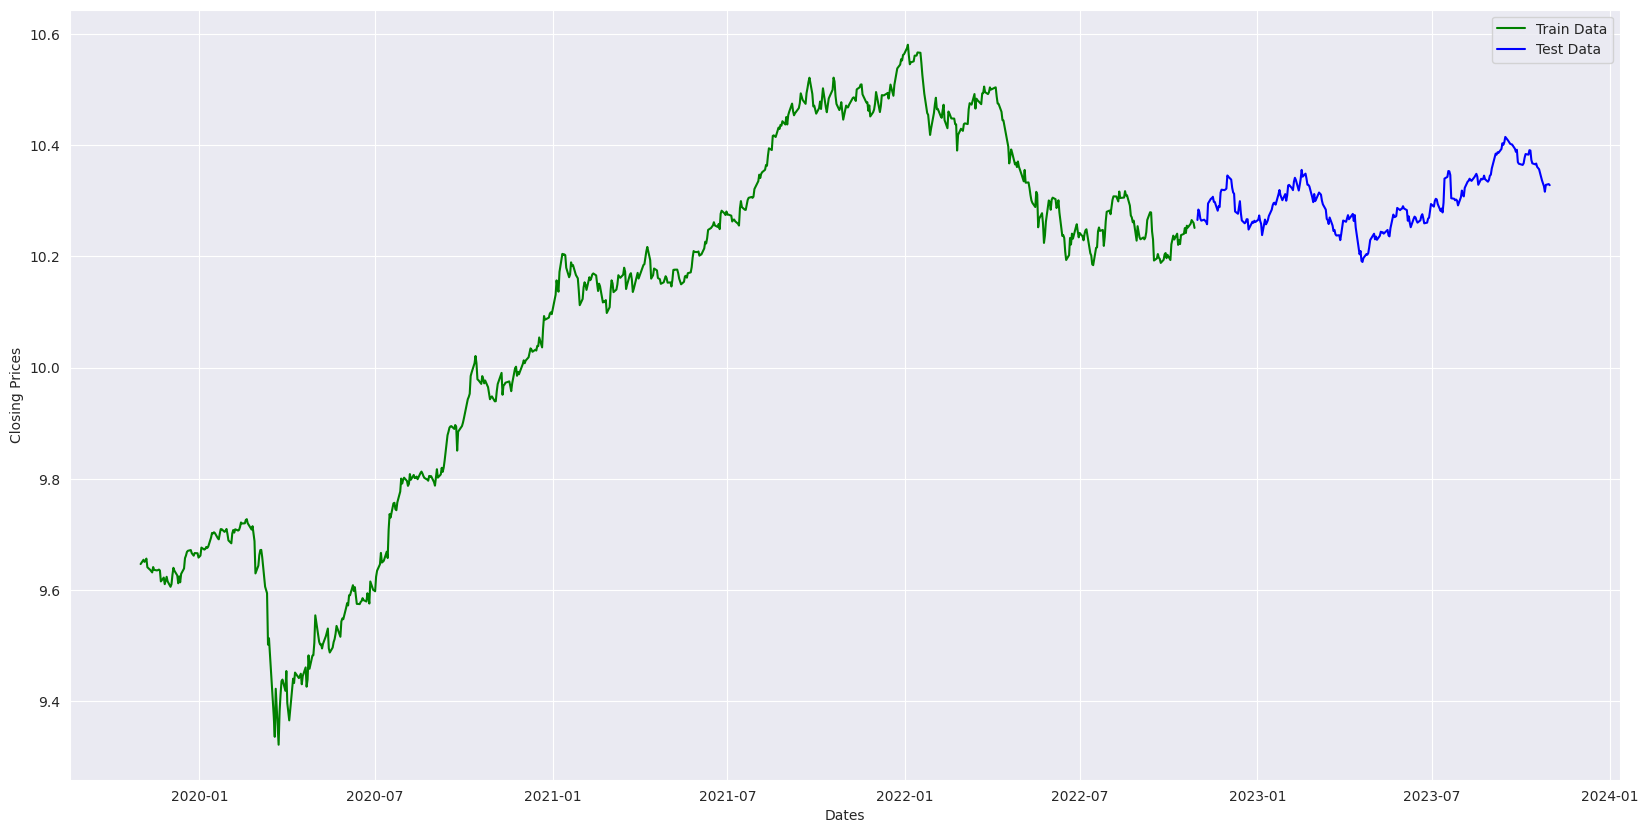

In [20]:
visualize_train_test_data(train_data, test_data)

In [21]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',
                   max_p=7, max_q=7,
                   m=1,
                   d=None,
                   seasonal=False,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3956.532, Time=1.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3956.182, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3956.110, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3956.754, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3953.921, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.569 seconds


In [22]:
model = ARIMA(train_data, order=(0, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  741
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1979.377
Date:                Wed, 29 Nov 2023   AIC                          -3956.754
Time:                        06:40:16   BIC                          -3952.147
Sample:                             0   HQIC                         -3954.978
                                - 741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   7.43e-06     37.393      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):              1052.13
Prob(Q):                              0.20   Pr

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
fc = fitted.forecast(len(test_data))

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
print_model_performance(test_data, fc)

MSE: 0.0047893711345976765
MAE: 0.05560161624690373


**BANK SECTOR ANALYSIS**

In [43]:
company = '^NSEBANK'
start="2019-11-01"
end="2023-11-01"
data_adj_close = load_adj_close_stock_data(company, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


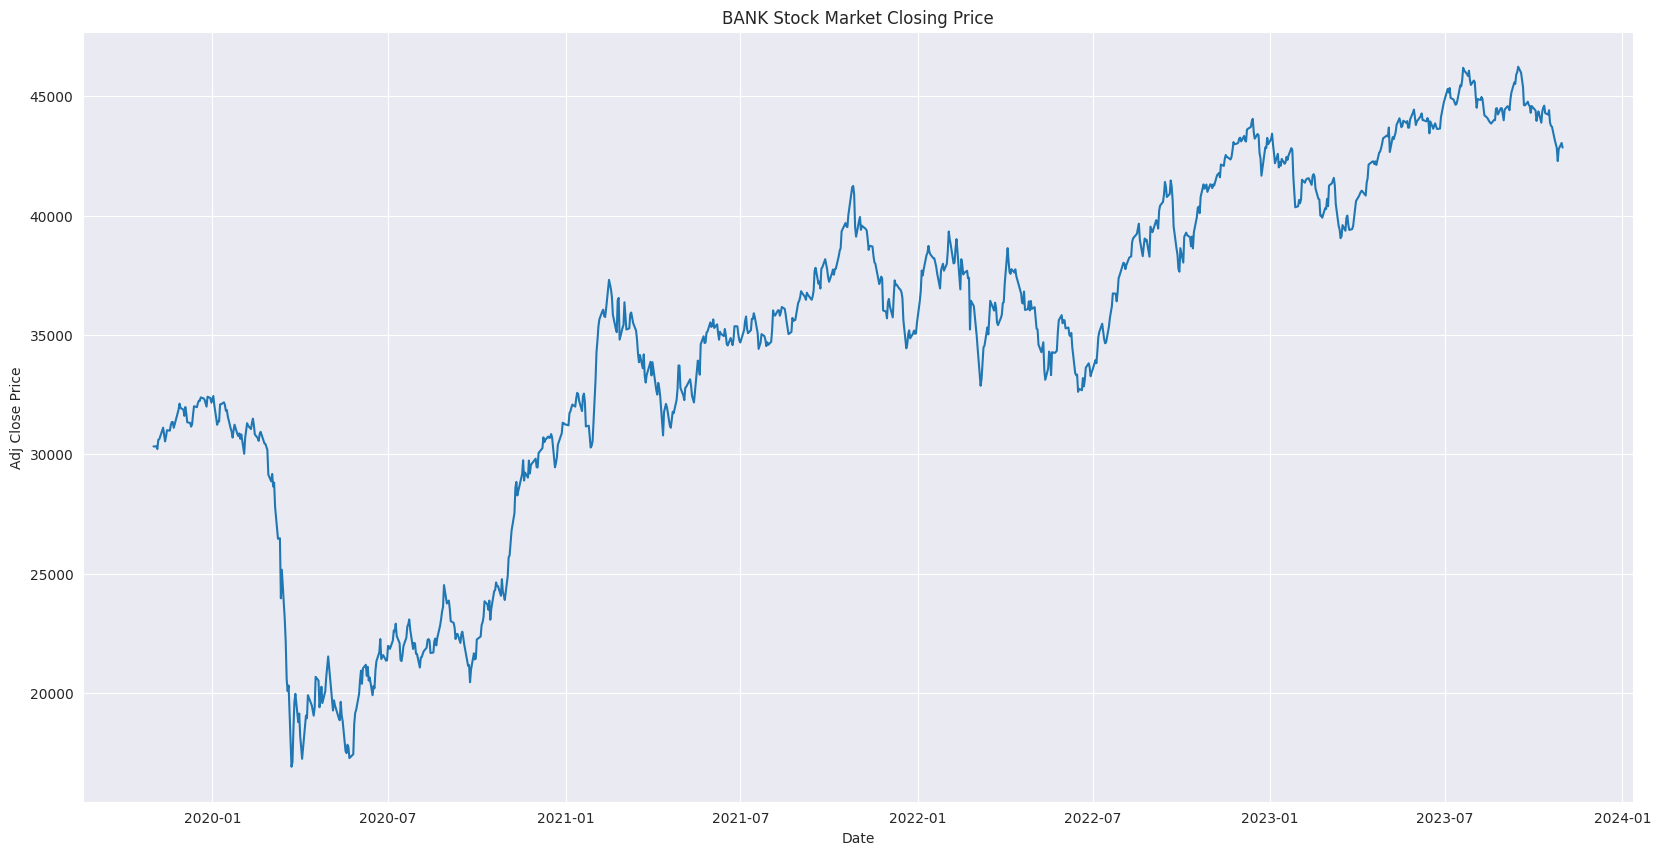

In [44]:
visualize_adj_close_stock_data("BANK", data_adj_close)

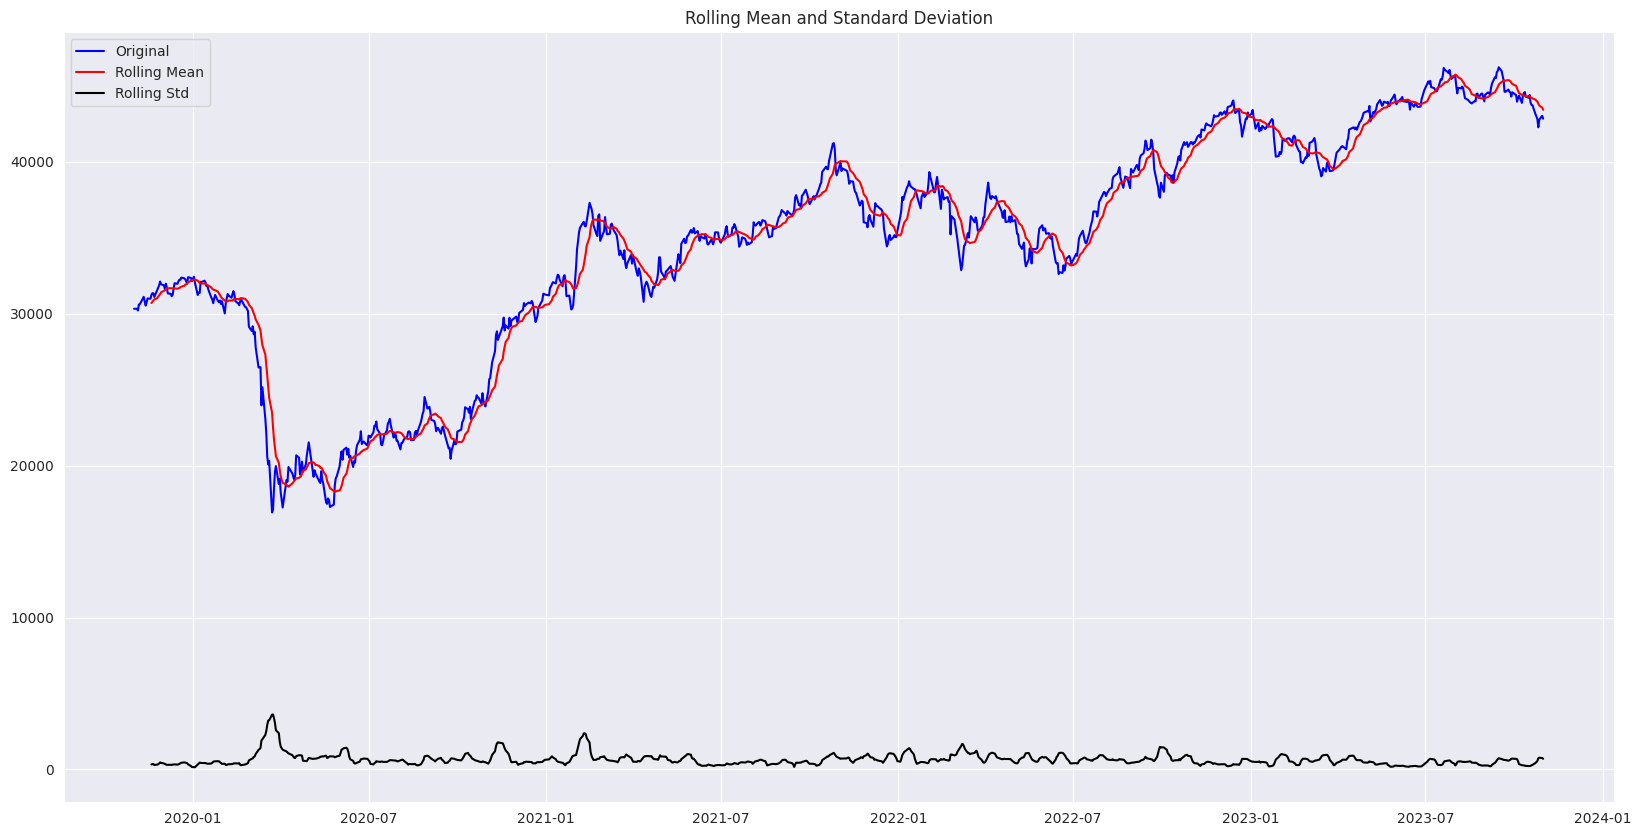

Results of dickey fuller test
Test Statistics                 -0.942585
p-value                          0.773626
No of lags used                  6.000000
Number of observations used    982.000000
Critical value (1%)             -3.437027
Critical value (5%)             -2.864488
Critical value (10%)            -2.568340
dtype: float64


In [45]:
test_adf(data_adj_close)

<Figure size 640x480 with 0 Axes>

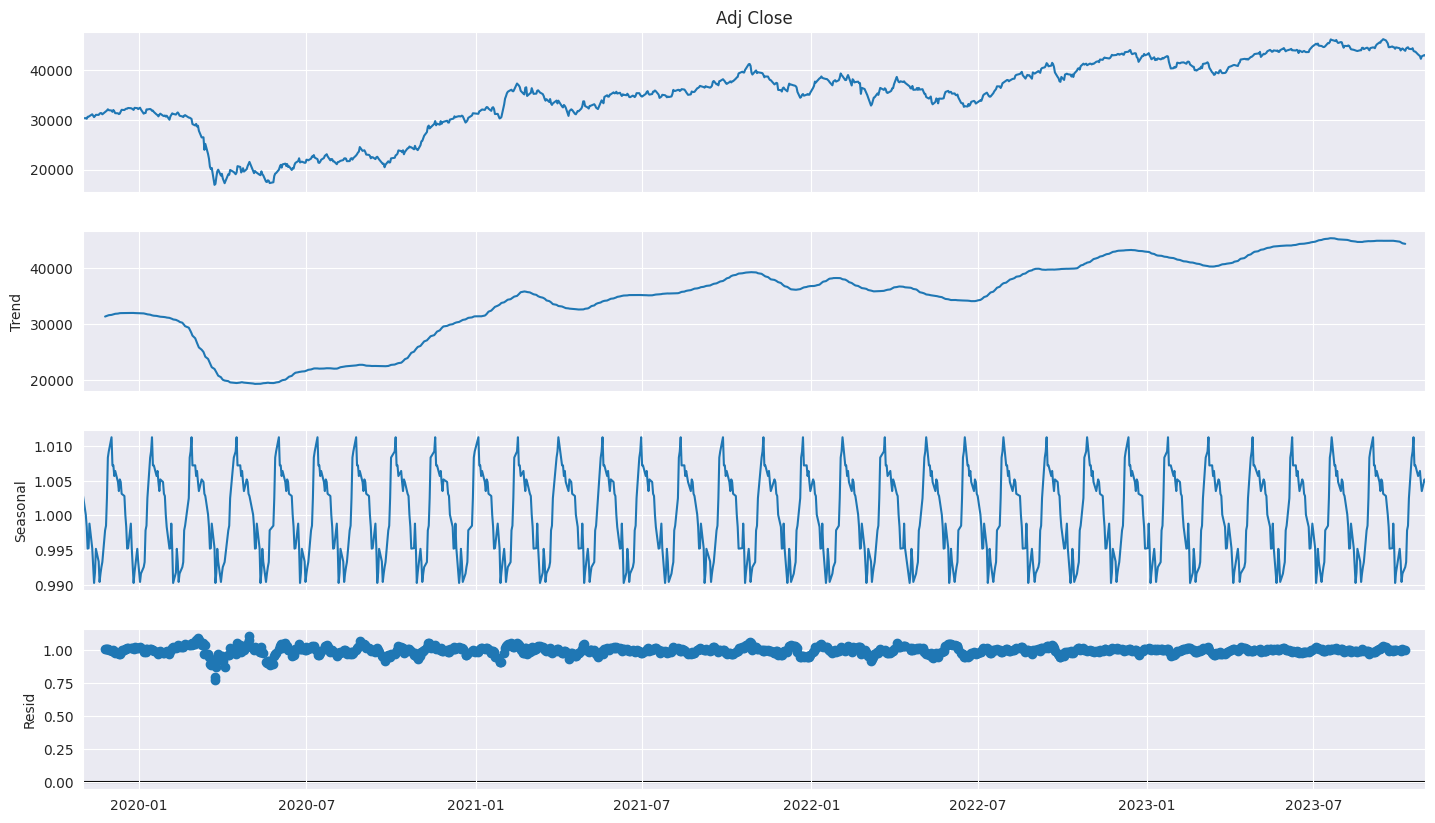

In [46]:
visualize_seasonal_decomposition(data_adj_close)

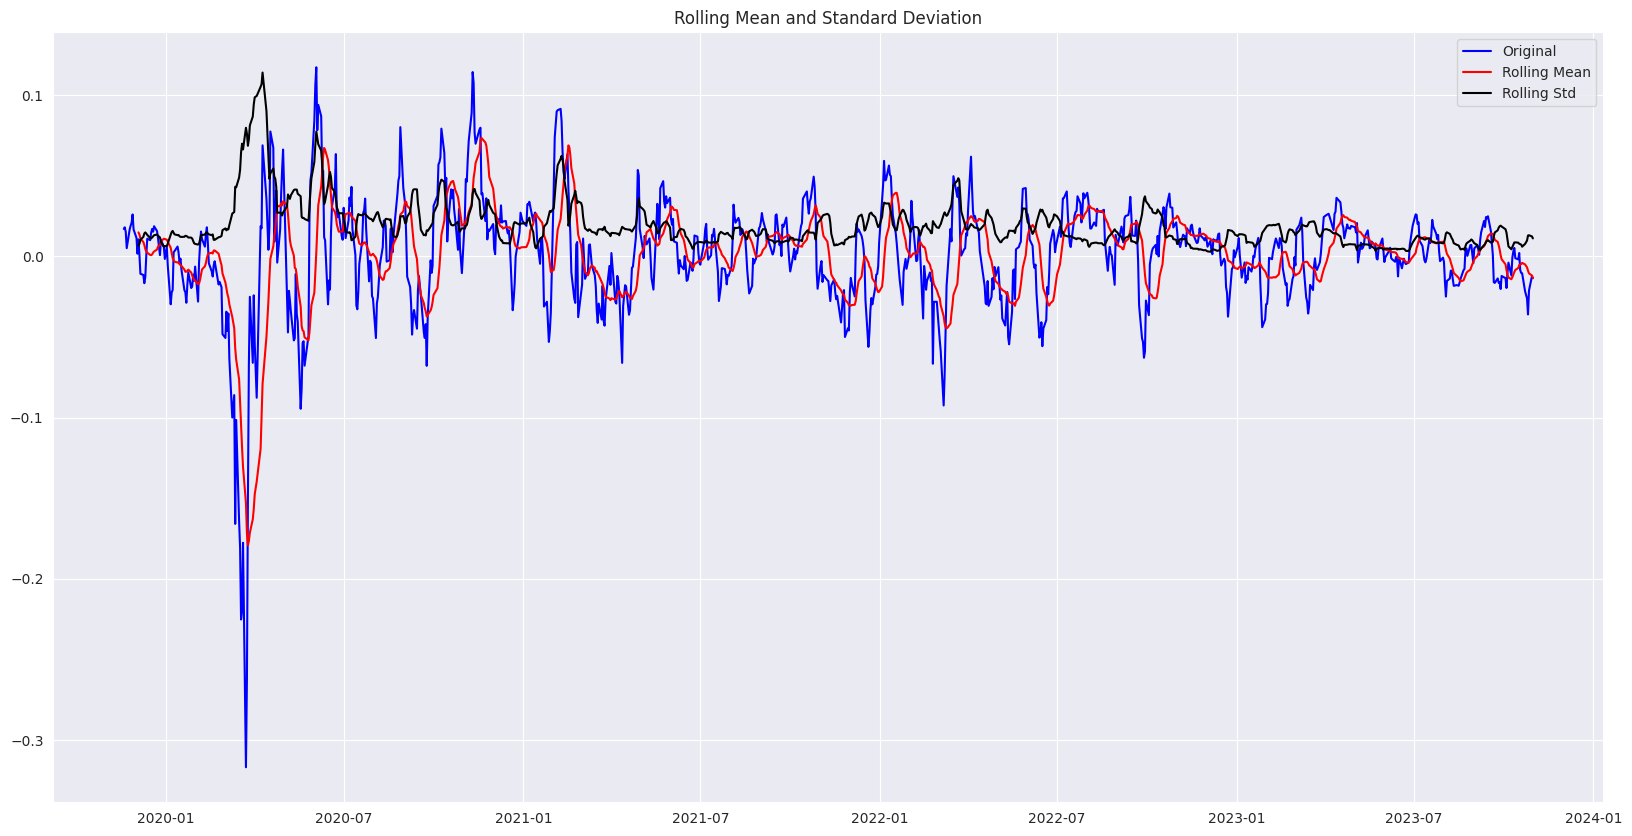

Results of dickey fuller test
Test Statistics               -6.413151e+00
p-value                        1.869175e-08
No of lags used                1.700000e+01
Number of observations used    9.600000e+02
Critical value (1%)           -3.437180e+00
Critical value (5%)           -2.864555e+00
Critical value (10%)          -2.568376e+00
dtype: float64


In [47]:
data_adj_close_log, data_adj_close_log_minus_mean = convert_to_stationary(data_adj_close)

In [48]:
train_data, test_data = train_test_split(data_adj_close_log)

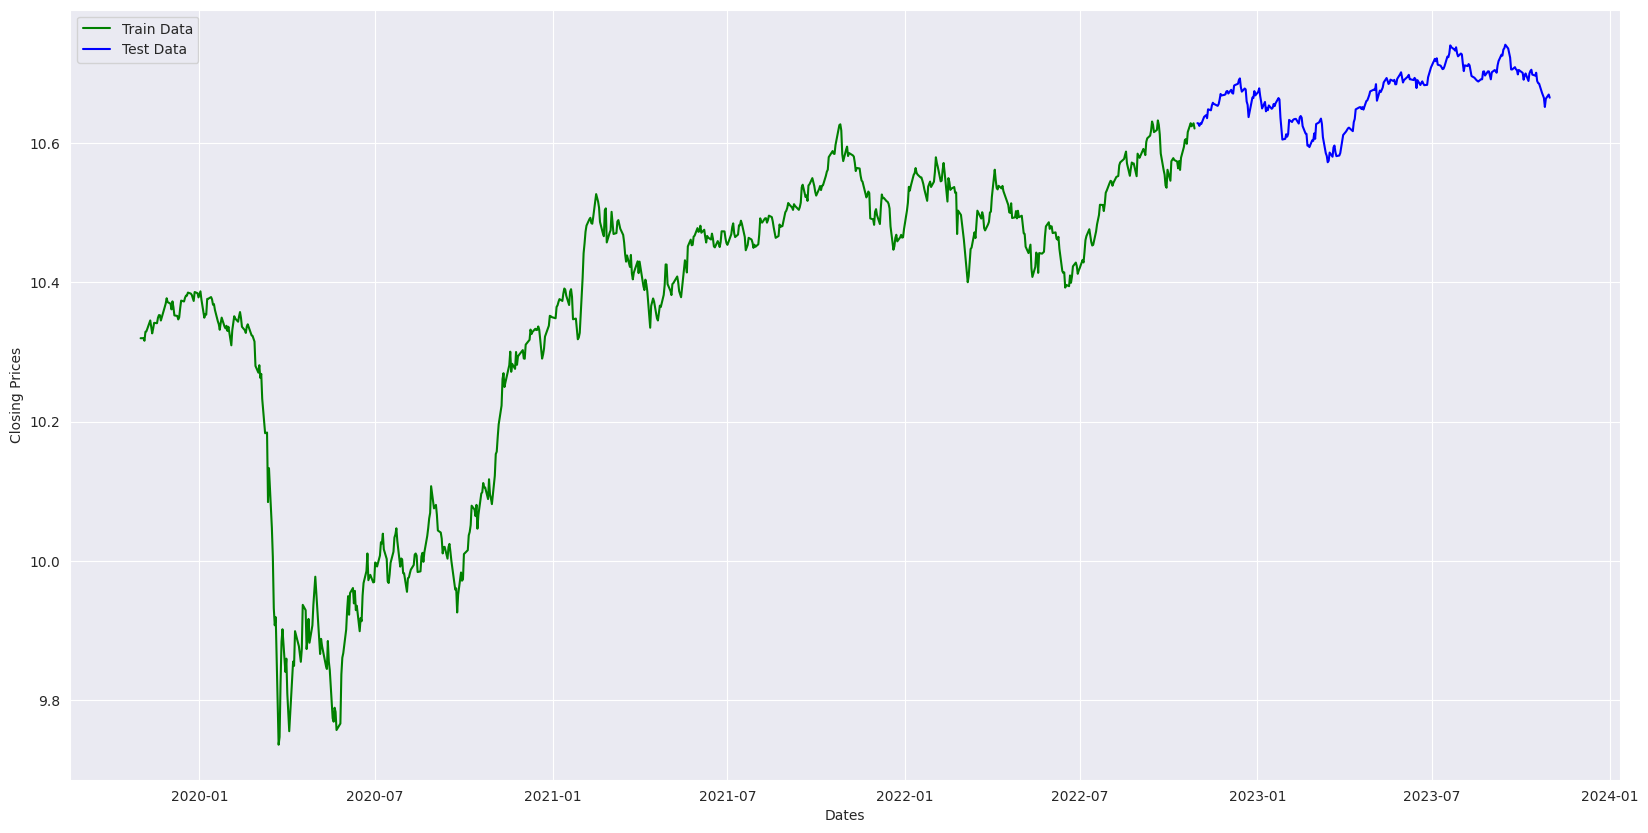

In [49]:
visualize_train_test_data(train_data, test_data)

In [50]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',
                   max_p=7, max_q=7,
                   m=1,
                   d=None,
                   seasonal=False,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3709.677, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3708.079, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3708.096, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3711.360, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3708.055, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.657 seconds


In [51]:
model = ARIMA(train_data, order=(0, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  741
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1856.680
Date:                Wed, 29 Nov 2023   AIC                          -3711.360
Time:                        06:51:45   BIC                          -3706.754
Sample:                             0   HQIC                         -3709.584
                                - 741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   7.27e-06     53.240      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):              5784.93
Prob(Q):                              0.53   Pr

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
fc = fitted.forecast(len(test_data))

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [61]:
print_model_performance(test_data, fc)

MSE: 0.00395141250208302
MAE: 0.055046179842311985


**FMCG SECTOR ANALYSIS**

In [55]:
company = '^CNXFMCG'
start="2019-11-01"
end="2023-11-01"
data_adj_close = load_adj_close_stock_data(company, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


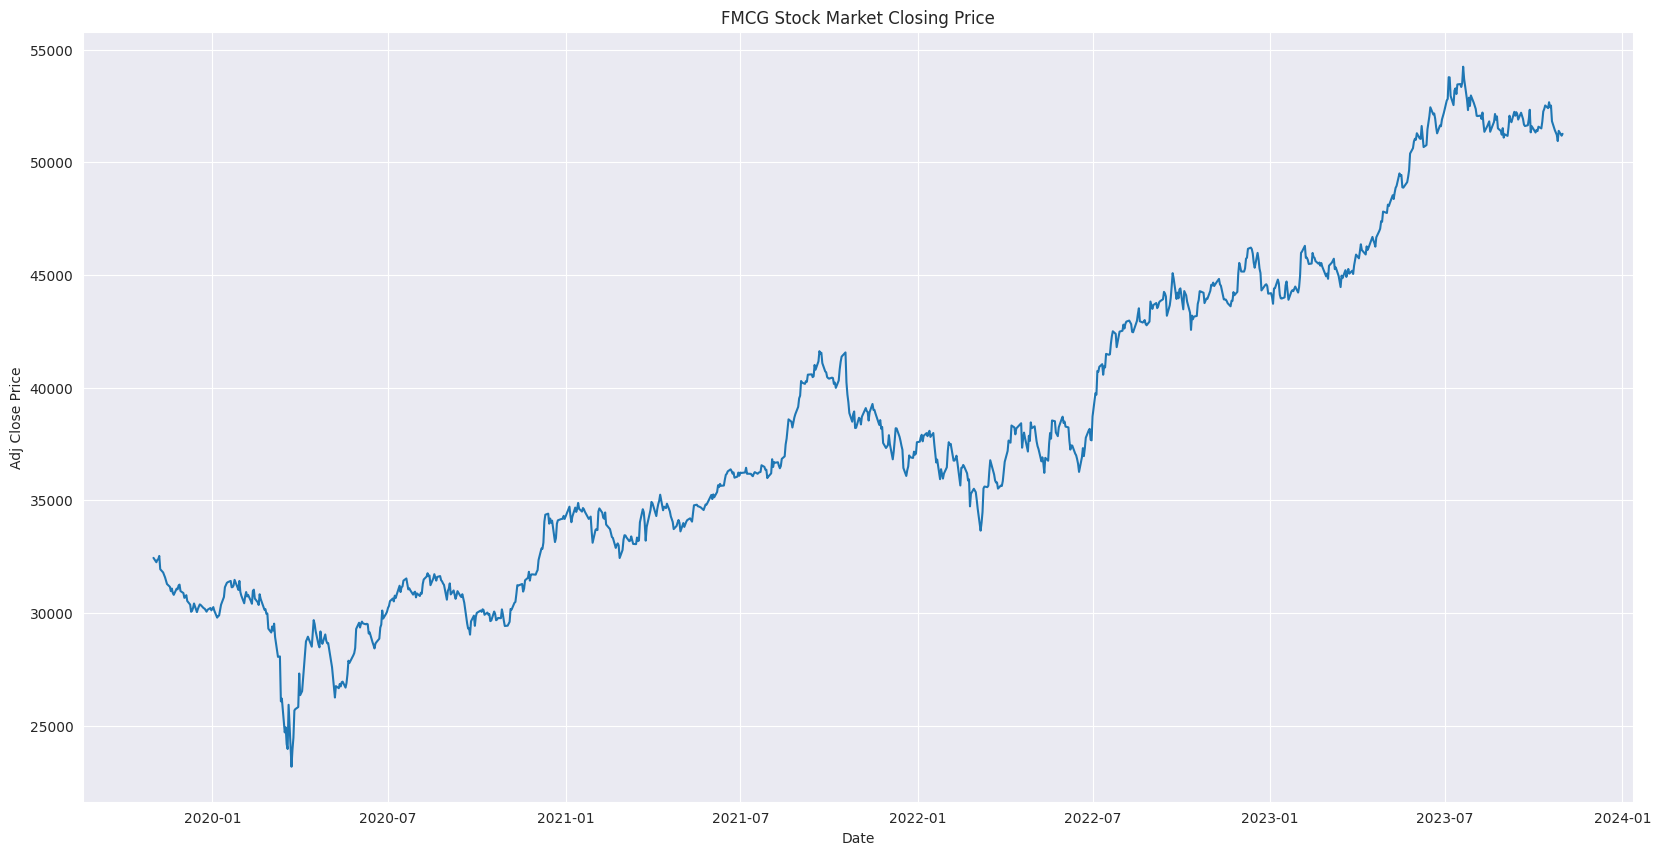

In [56]:
visualize_adj_close_stock_data("FMCG", data_adj_close)

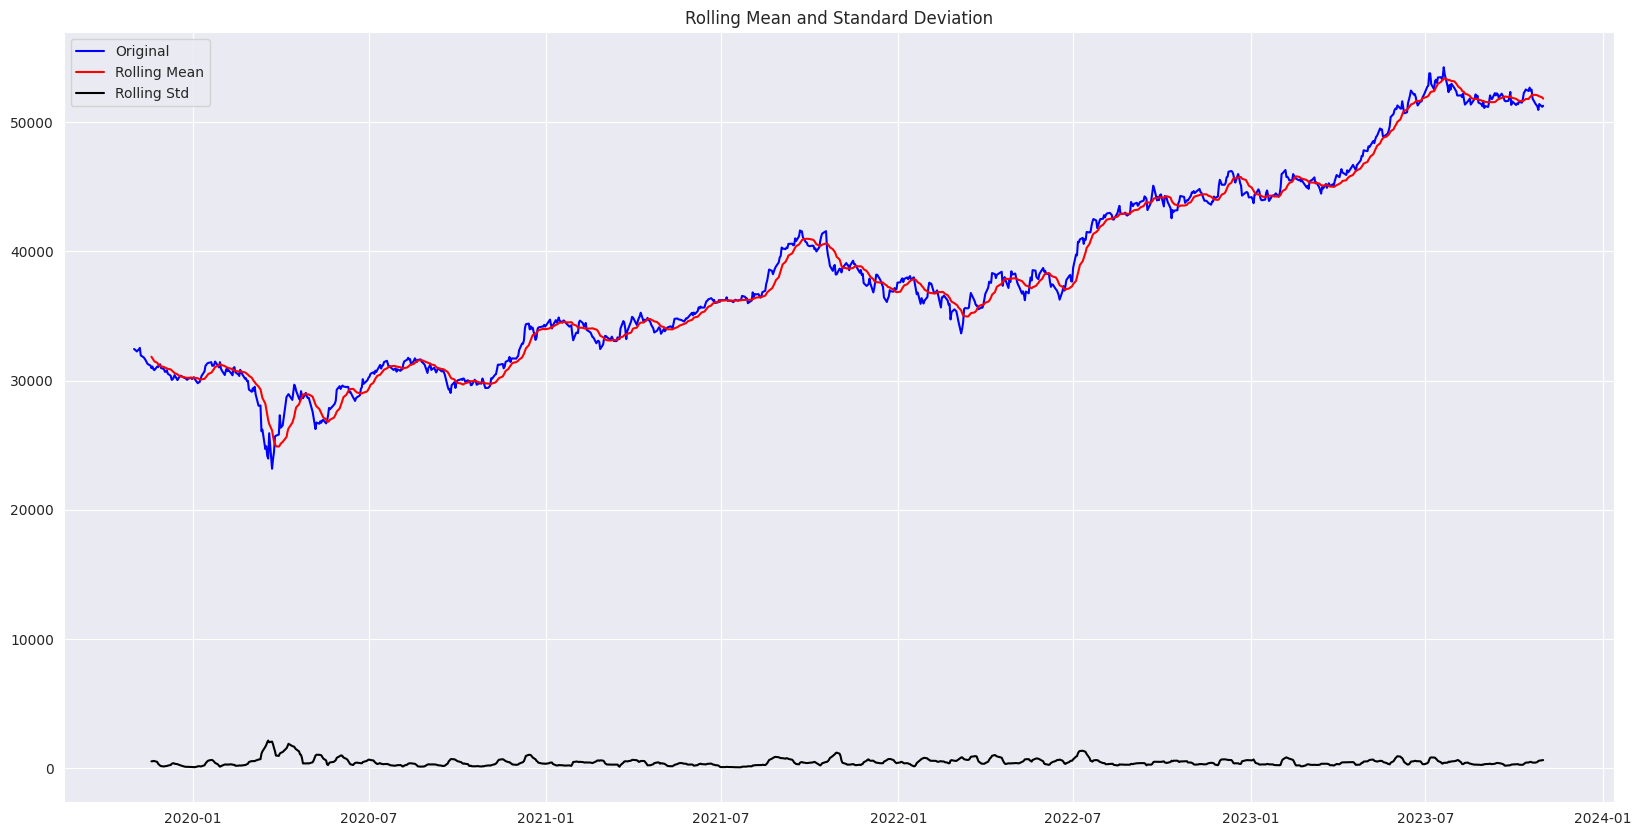

Results of dickey fuller test
Test Statistics                 -0.192668
p-value                          0.939390
No of lags used                 10.000000
Number of observations used    969.000000
Critical value (1%)             -3.437116
Critical value (5%)             -2.864527
Critical value (10%)            -2.568361
dtype: float64


In [57]:
test_adf(data_adj_close)

<Figure size 640x480 with 0 Axes>

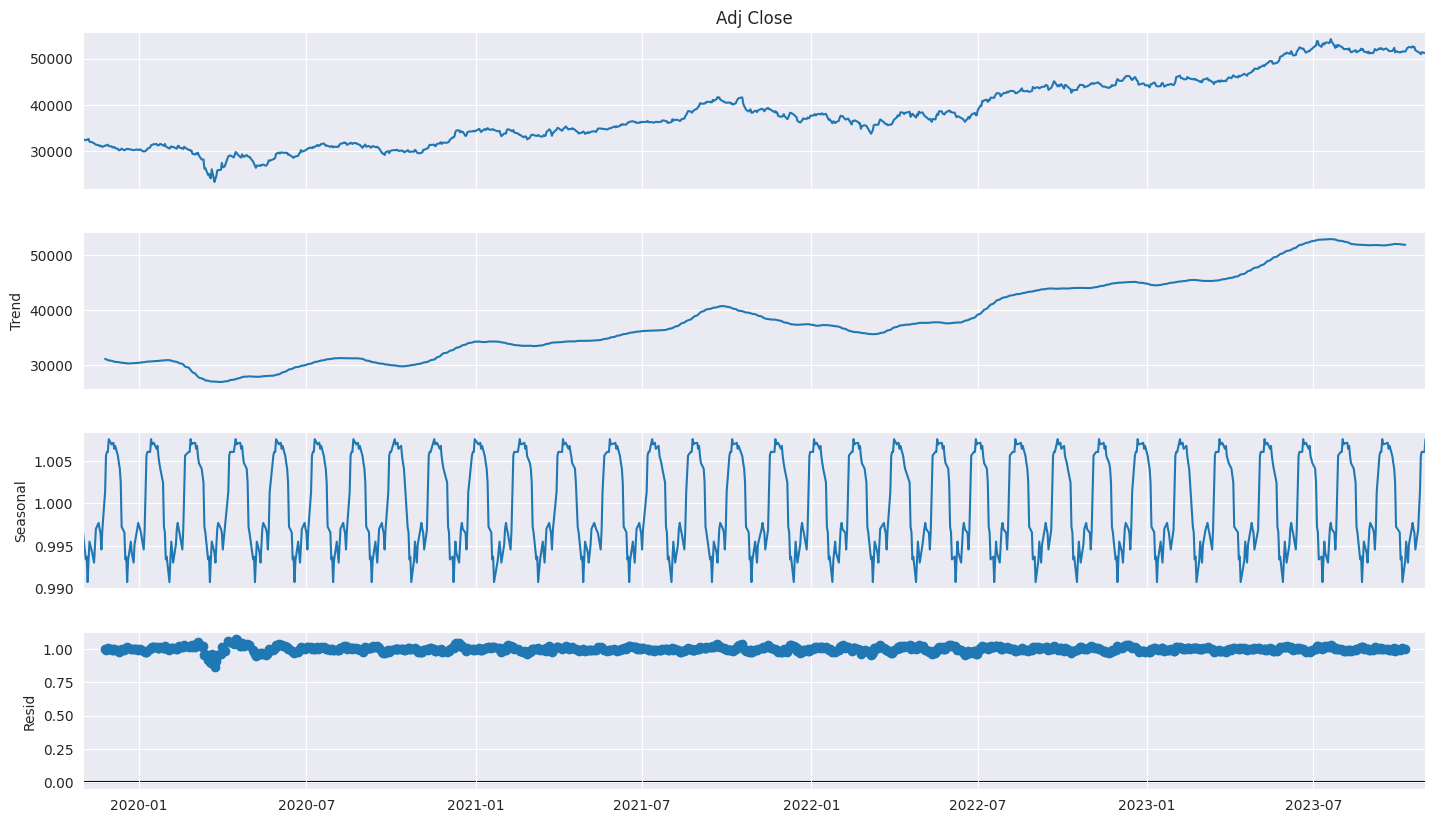

In [58]:
visualize_seasonal_decomposition(data_adj_close)

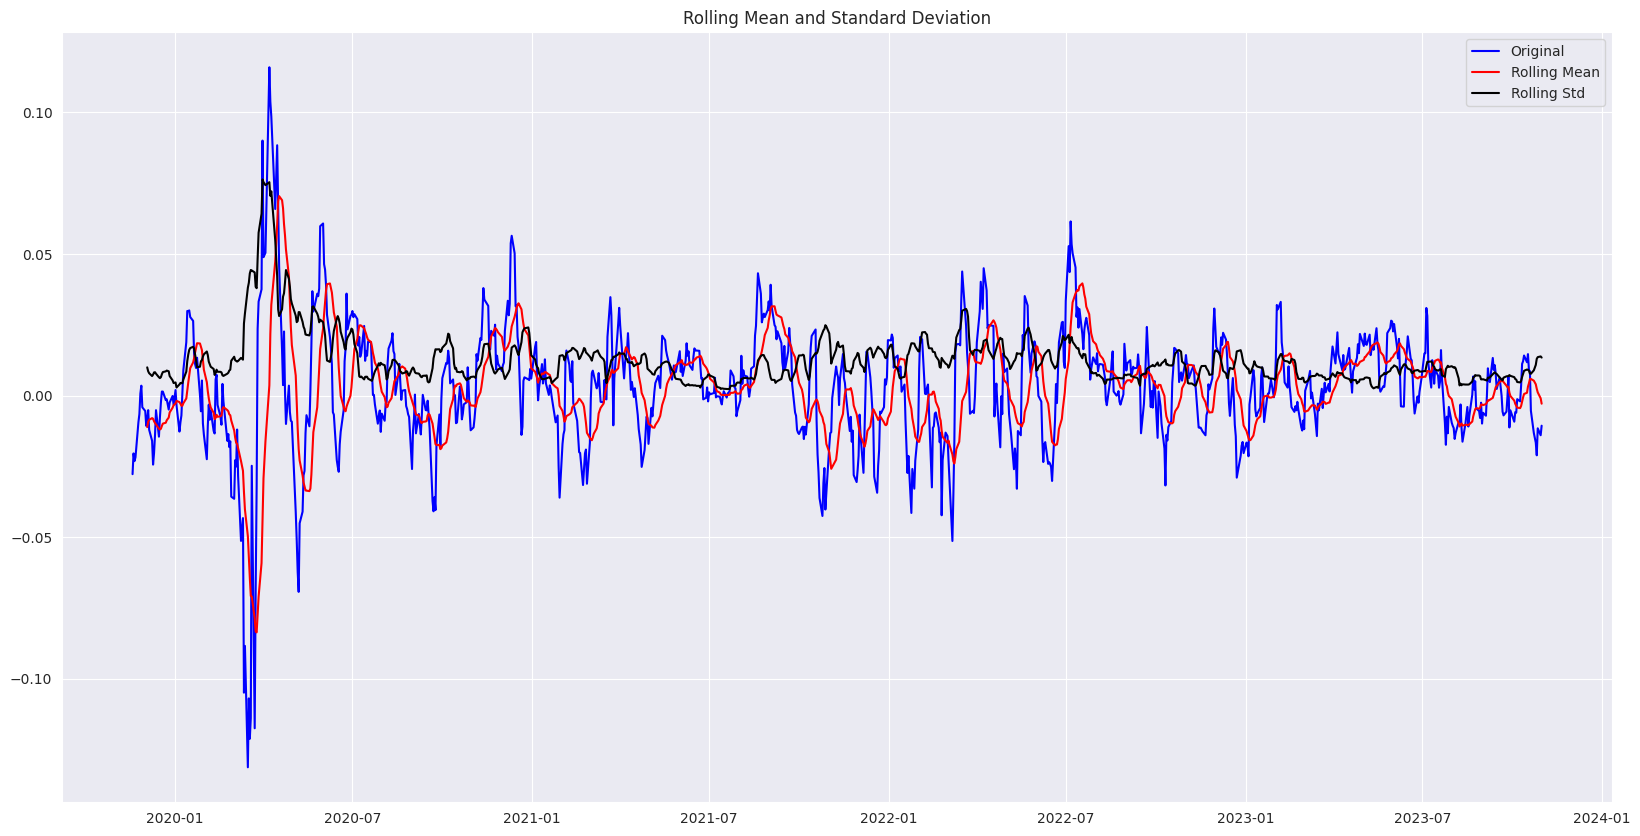

Results of dickey fuller test
Test Statistics               -8.393232e+00
p-value                        2.335987e-13
No of lags used                1.200000e+01
Number of observations used    9.560000e+02
Critical value (1%)           -3.437209e+00
Critical value (5%)           -2.864568e+00
Critical value (10%)          -2.568382e+00
dtype: float64


In [59]:
data_adj_close_log, data_adj_close_log_minus_mean = convert_to_stationary(data_adj_close)

In [60]:
train_data, test_data = train_test_split(data_adj_close_log)

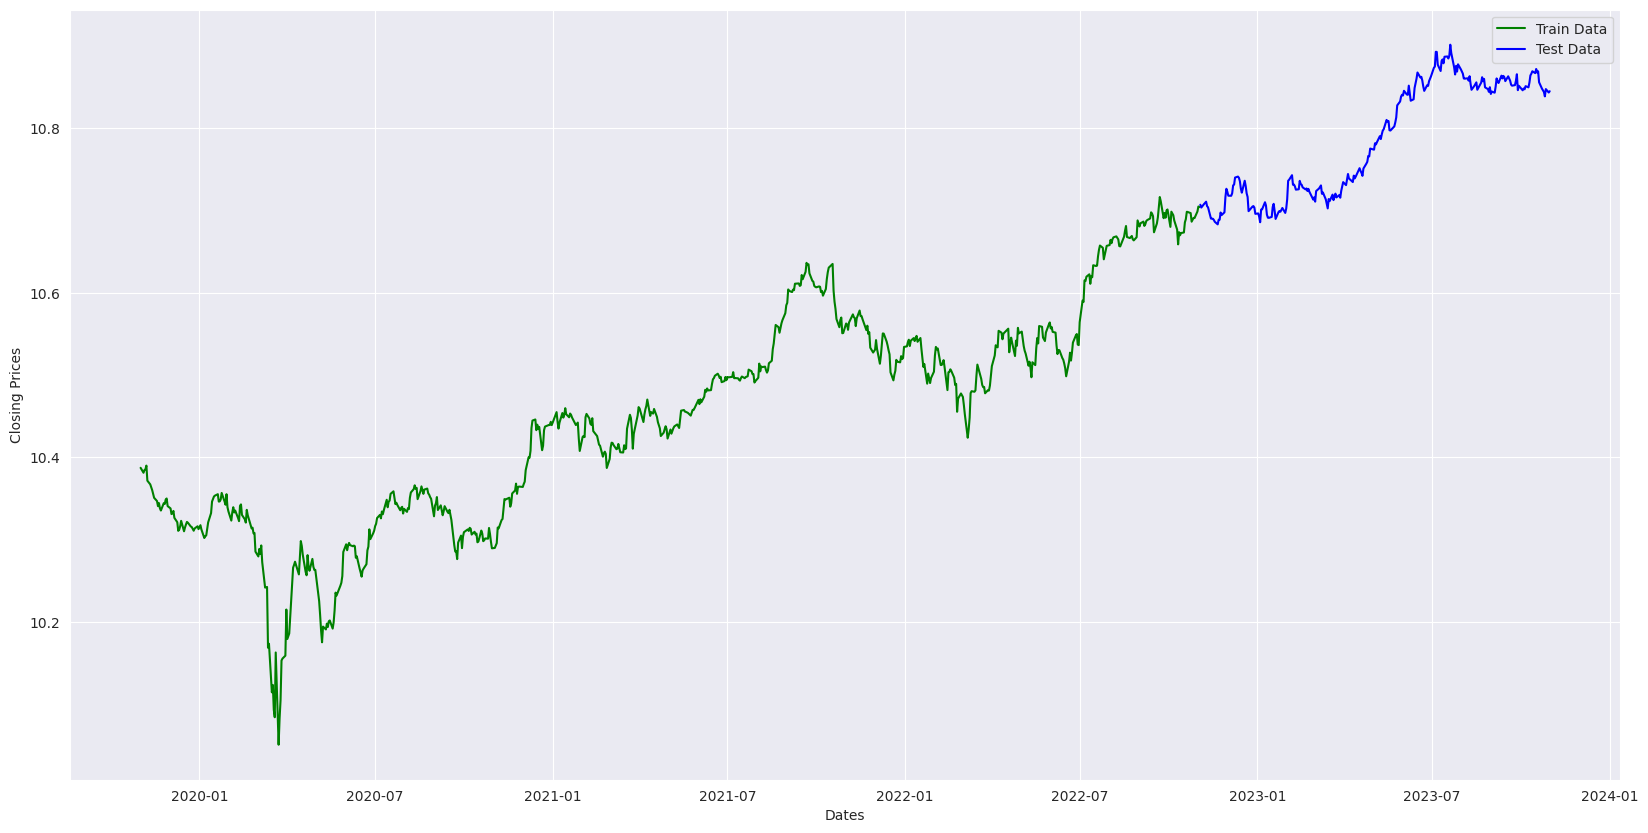

In [61]:
visualize_train_test_data(train_data, test_data)

In [62]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',
                   max_p=7, max_q=7,
                   m=1,
                   d=None,
                   seasonal=False,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4362.423, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4367.534, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4366.814, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4363.530, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4367.056, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4365.977, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4365.299, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4368.444, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4368.062, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4366.922, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4367.730, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4366.312, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.637 seconds


In [63]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  735
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2186.222
Date:                Wed, 29 Nov 2023   AIC                          -4368.444
Time:                        06:53:59   BIC                          -4359.247
Sample:                             0   HQIC                         -4364.896
                                - 735                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0969      0.019     -4.972      0.000      -0.135      -0.059
sigma2         0.0002   3.38e-06     44.847      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [64]:
fc = fitted.forecast(len(test_data))

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [66]:
print_model_performance(test_data, fc)

MSE: 0.011483457317498976
MAE: 0.08399281529363889


**AUTOMOBILE SECTOR ANALYSIS**

In [67]:
company = '^CNXAUTO'
start="2019-11-01"
end="2023-11-01"
data_adj_close = load_adj_close_stock_data(company, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


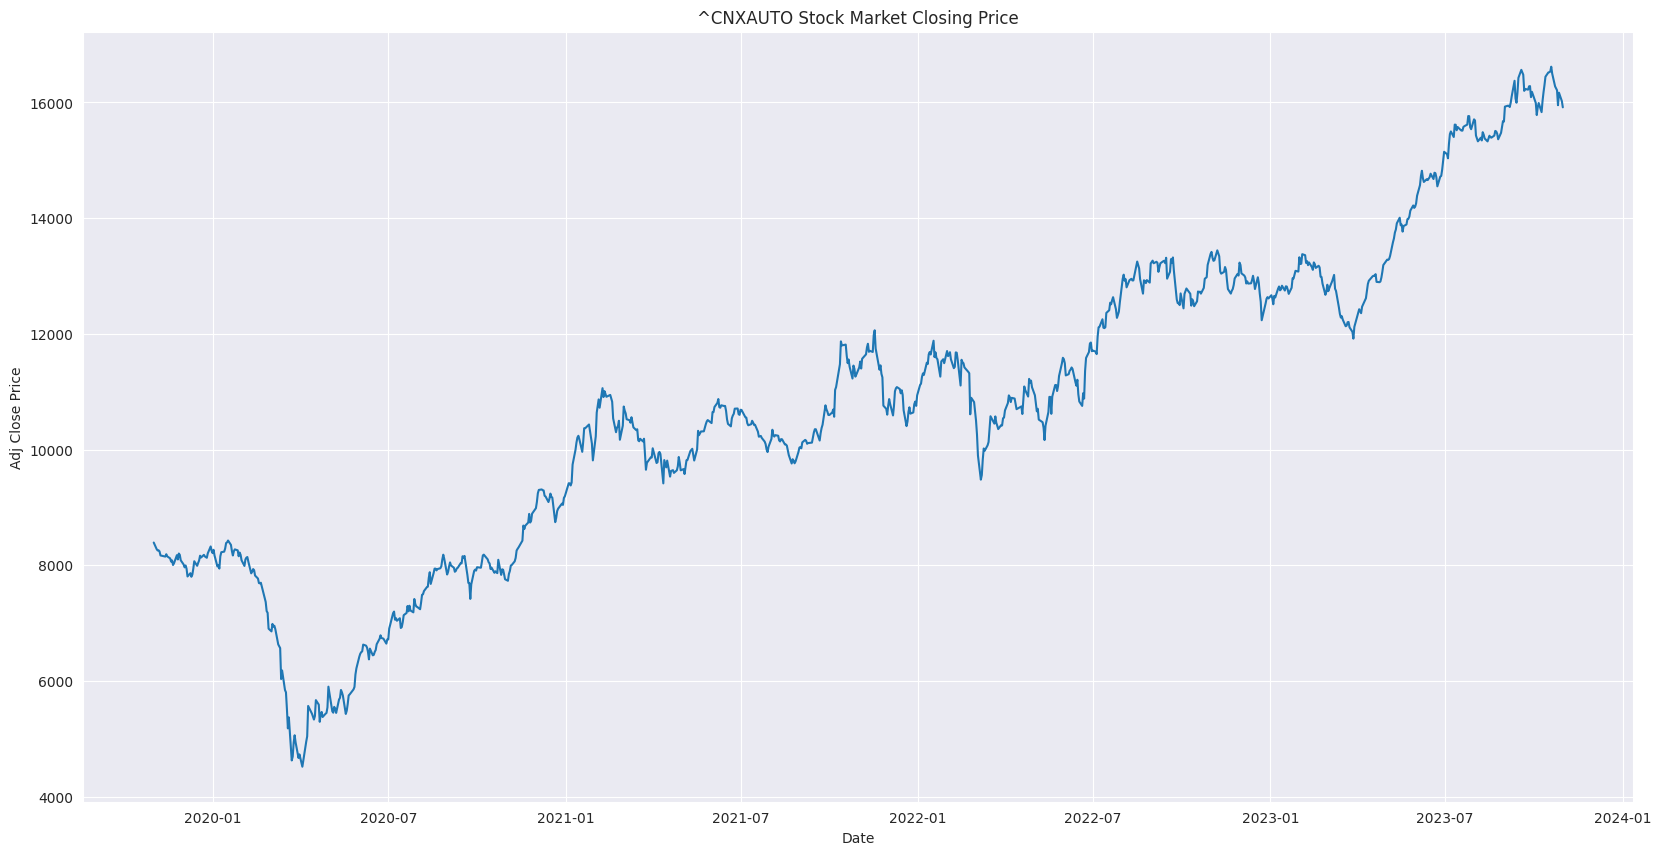

In [68]:
visualize_adj_close_stock_data(company, data_adj_close)

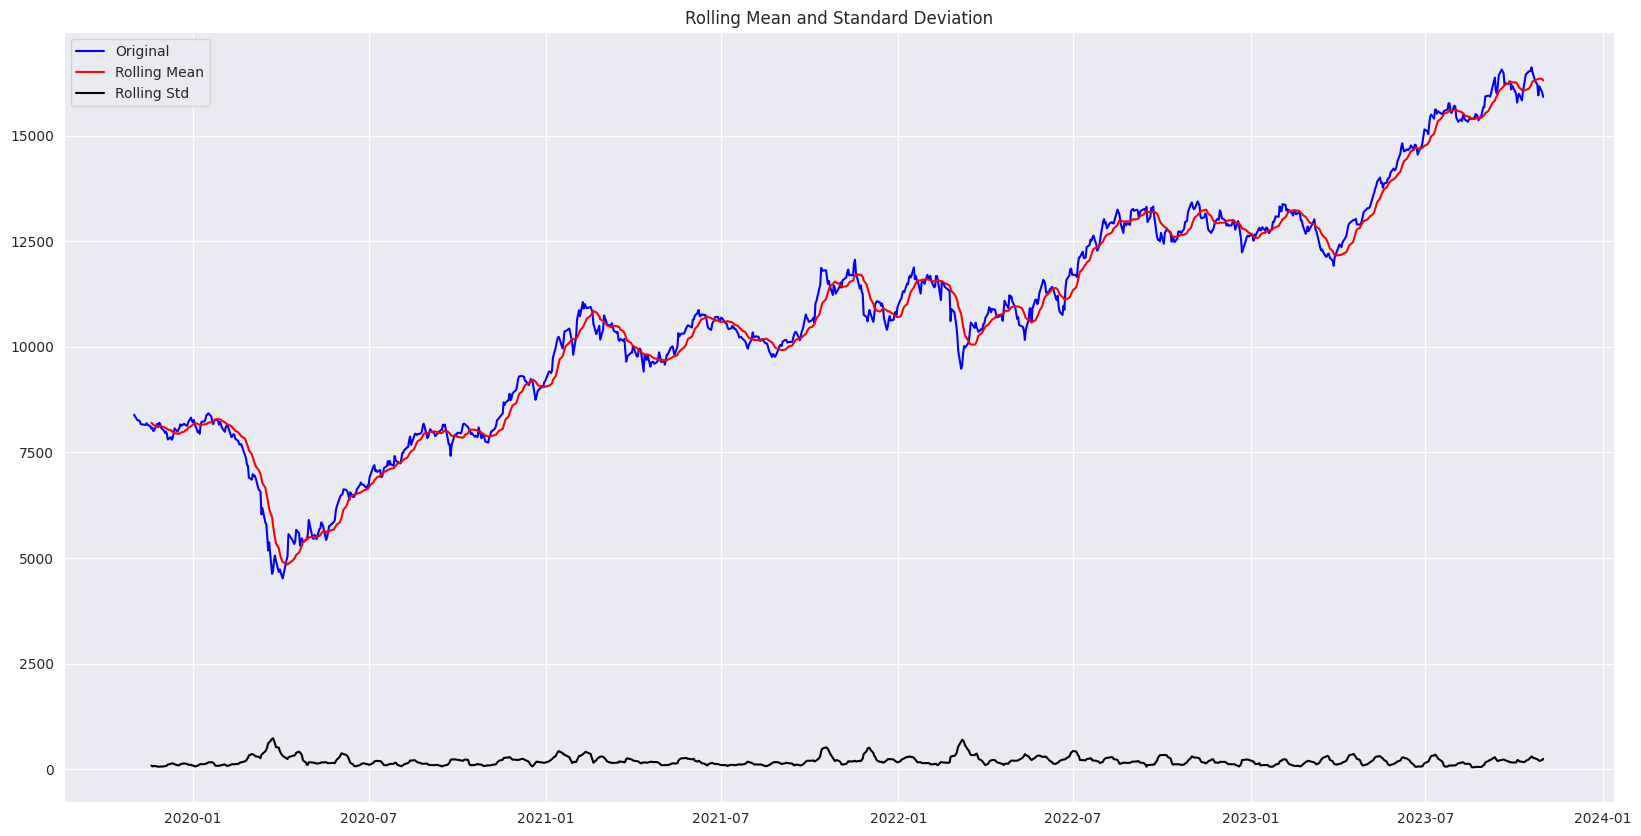

Results of dickey fuller test
Test Statistics                  0.060065
p-value                          0.963226
No of lags used                  0.000000
Number of observations used    980.000000
Critical value (1%)             -3.437040
Critical value (5%)             -2.864494
Critical value (10%)            -2.568343
dtype: float64


In [69]:
test_adf(data_adj_close)

<Figure size 640x480 with 0 Axes>

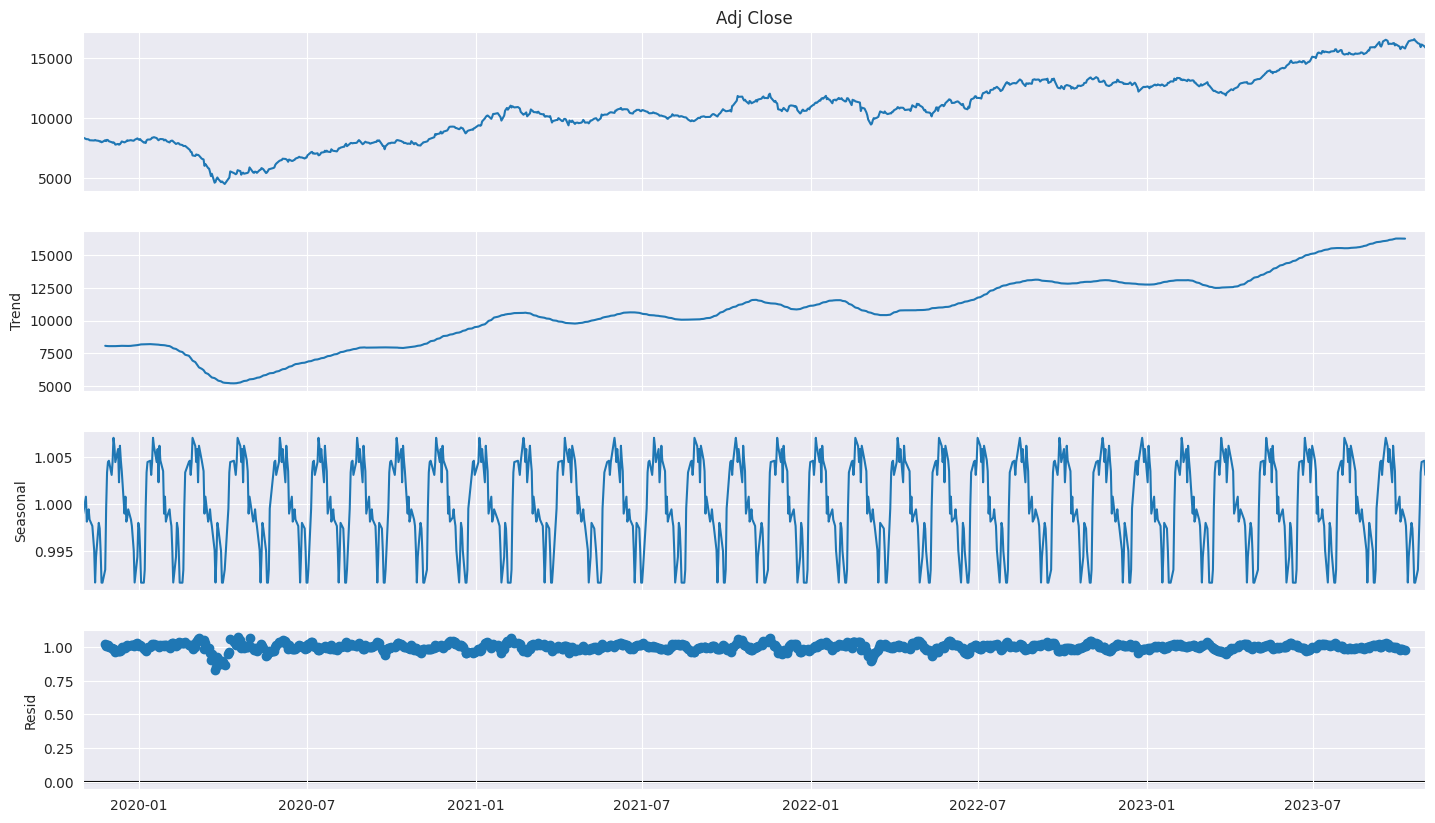

In [70]:
visualize_seasonal_decomposition(data_adj_close)

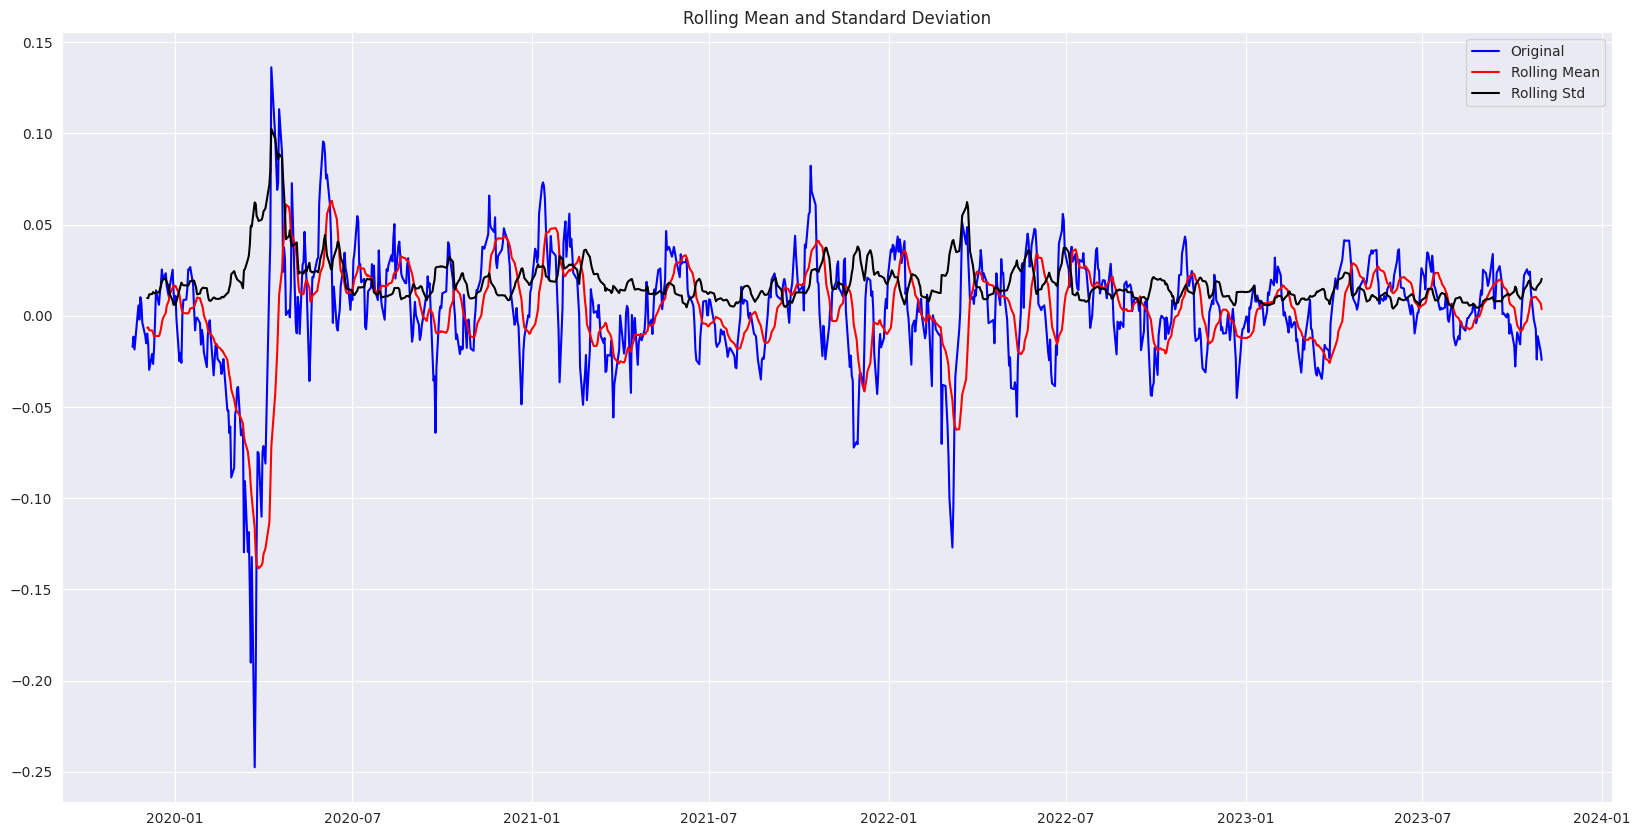

Results of dickey fuller test
Test Statistics               -6.108540e+00
p-value                        9.454866e-08
No of lags used                1.200000e+01
Number of observations used    9.570000e+02
Critical value (1%)           -3.437202e+00
Critical value (5%)           -2.864565e+00
Critical value (10%)          -2.568381e+00
dtype: float64


In [71]:
data_adj_close_log, data_adj_close_log_minus_mean = convert_to_stationary(data_adj_close)

In [72]:
train_data, test_data = train_test_split(data_adj_close_log)

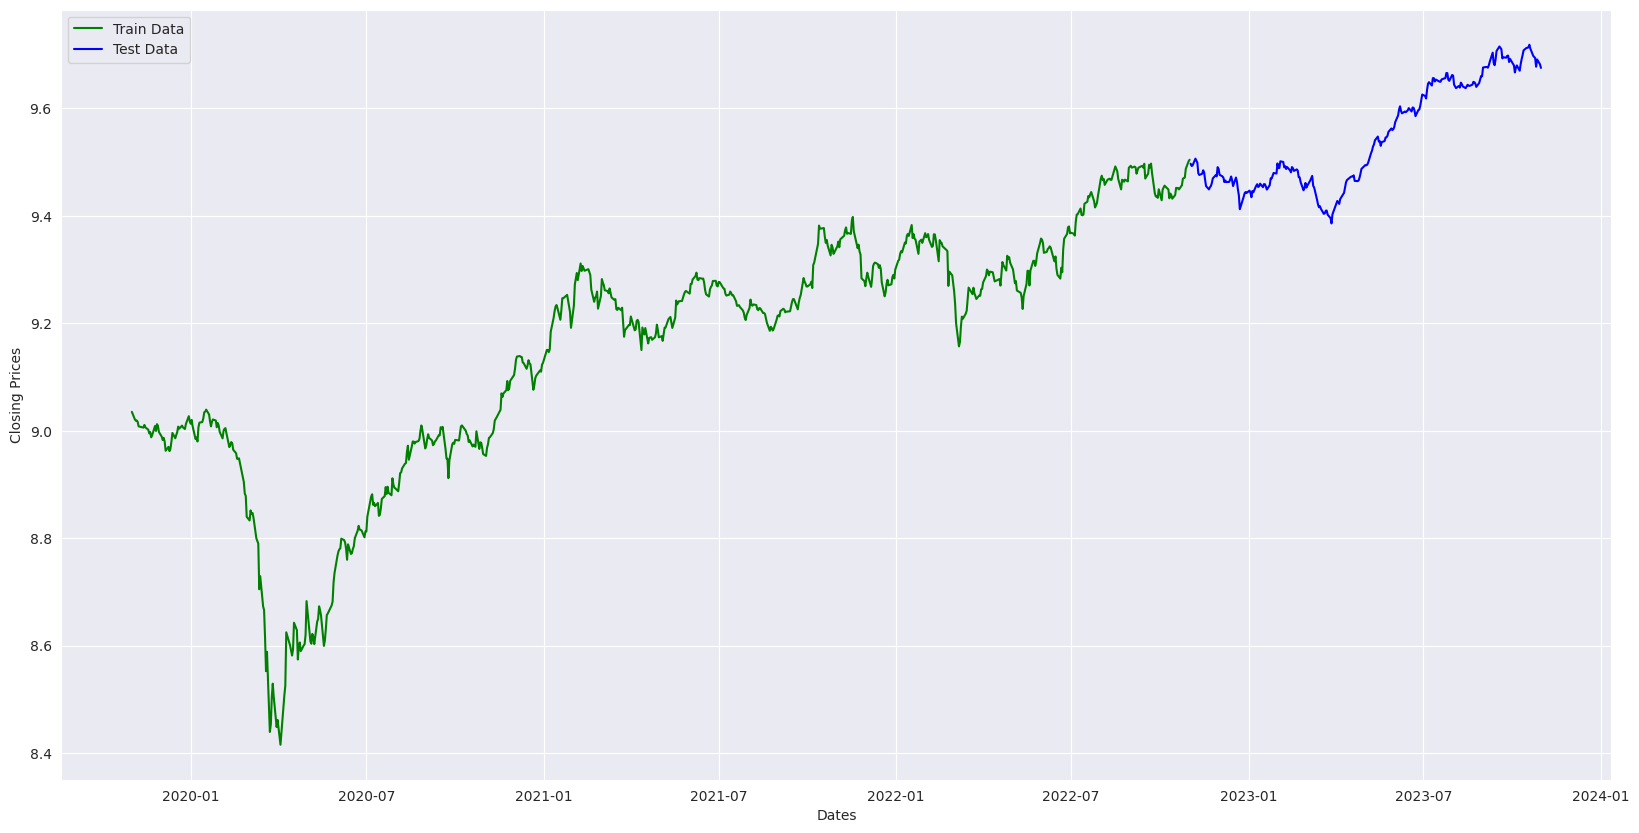

In [73]:
visualize_train_test_data(train_data, test_data)

In [74]:
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',
                   max_p=7, max_q=7,
                   m=1,
                   d=None,
                   seasonal=False,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3834.359, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3832.588, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3832.568, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3835.403, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3830.885, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.759 seconds


In [87]:
model = ARIMA(train_data, order=(0, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  735
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1918.702
Date:                Wed, 29 Nov 2023   AIC                          -3835.403
Time:                        07:50:50   BIC                          -3830.805
Sample:                             0   HQIC                         -3833.630
                                - 735                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   6.59e-06     47.612      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              3472.54
Prob(Q):                              0.63   Pr

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [88]:
fc = fitted.forecast(len(test_data))

/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/aerondight/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [90]:
print_model_performance(test_data, fc)

MSE: 0.011436535002346955
MAE: 0.08773457896658679
